## **Can <font color='darkred'>Heart Disease</font> be predicted?**

**Analysis By:**

Lisa Desjarlais, Shreyas Goyal, and Emma Szeto _(Group 155)._

**Introduction:**
    
According to medical professionals at Johns Hopkins and Mount Sinai Health, there are five classifications of heart disease  <a href="https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack">(Johns Hopkins Medicine 2017)</a>. For our project we will be analyzing the <a href="https://archive.ics.uci.edu/ml/datasets/Heart+Disease">Cleveland Heart Disease Data set.</a> Class 0 indicates no presence of heart disease, while classes 1 to 4 describe mild, moderate, severe and very severe heart disease, in that order. The data was compiled using the medical information of 303 patients. Each row in the data set represents a patient with some classification of heart disease and 13 other health attributes. The goal of our project is to answer the predictive question: Can we use these health attributes available to us to predict whether a future patient (with an unknown diagnosis) has some level of heart disease?

**Methods & Results**

**Preprocessing the Data**

In [96]:
# Loading in all necessary libraries.

library(tidyverse)
library(tidymodels)
library(repr)
library(GGally)
options(repr.matrix.max.rows = 10)

# Setting the seed.
set.seed(14)

In [97]:
# Loading in Cleveland data set

URL <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

cleveland_data <- read_csv(URL, col_names=FALSE, show_col_types = FALSE)

# Since column names aren't pre-specified, we rename them using colnames, according to the UCI repository.

colnames(cleveland_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")

cleveland_data <- cleveland_data |>
    mutate(ca = as.numeric(ca), thal = as.numeric(thal), num = as.factor(num)) |>
    filter(ca != "NA", thal != "NA")
cleveland_data

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
41,0,2,130,204,0,2,172,0,1.4,1,0,3,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
57,0,4,140,241,0,0,123,1,0.2,2,0,7,1
45,1,1,110,264,0,0,132,0,1.2,2,0,7,1
68,1,4,144,193,1,0,141,0,3.4,2,2,7,2


The columns in the data represent:

1. age: age in years
2. sex: biological sex (1 = male, 0 = female)
3. cp: chest pain type (1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic)
4. trestbps: resting blood pressure (in mm Hg on admission to the hospital) 
5. chol: serum cholestoral in mg/dl 
6. fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false) 
7. restecg: resting electrocardiographic results 
   (0 = normal, 1 = having ST-T wave abnormality, 2 = probable left ventricular hypertrophy)
8. thalach: maximum heart rate achieved 
9. exang: exercise induced angina (1 = yes; 0 = no) 
10. oldpeak: ST depression induced by exercise relative to rest 
11. slope: the slope of the peak exercise ST segment (1 = upsloping, 2 = flat, 3 = downsloping)
12. ca: number of major vessels (0-3) colored by flourosopy 
13. thal: presence of heart defect (3 = normal, 6 = fixed defect, 7 = reversable defect)
14. num: diagnosis of heart disease (0 = none, 1 = mild, 2 = moderate, 3 = severe, 4 = very severe)

**Exploratory Data Analysis:**

During our exploration of the data, we were unable to conclusively visualize relationships in our data set, and we elected to classify based on simply having heart disease to not having heart disease:

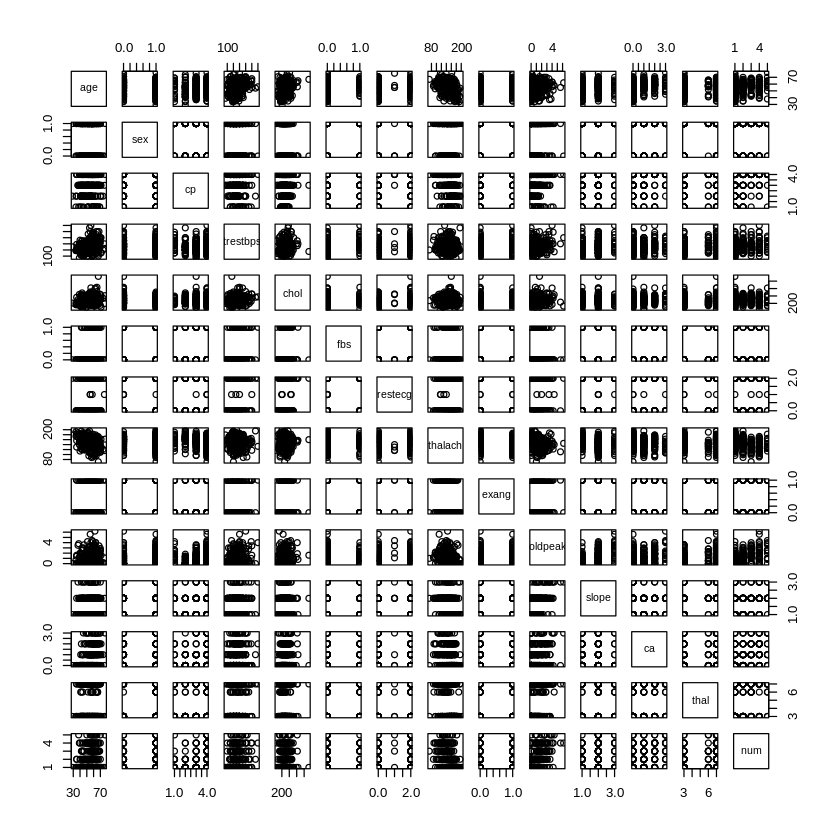

In [98]:
# Using the _pairs()_ function from the GGally library.

pairs(cleveland_data)

From this visualization, it is hard to see any clear relationships.

So, we create a larger plot of _cholesterol_ against _resting blood pressure_, with each severity of heart disease colorized and as different subplots.

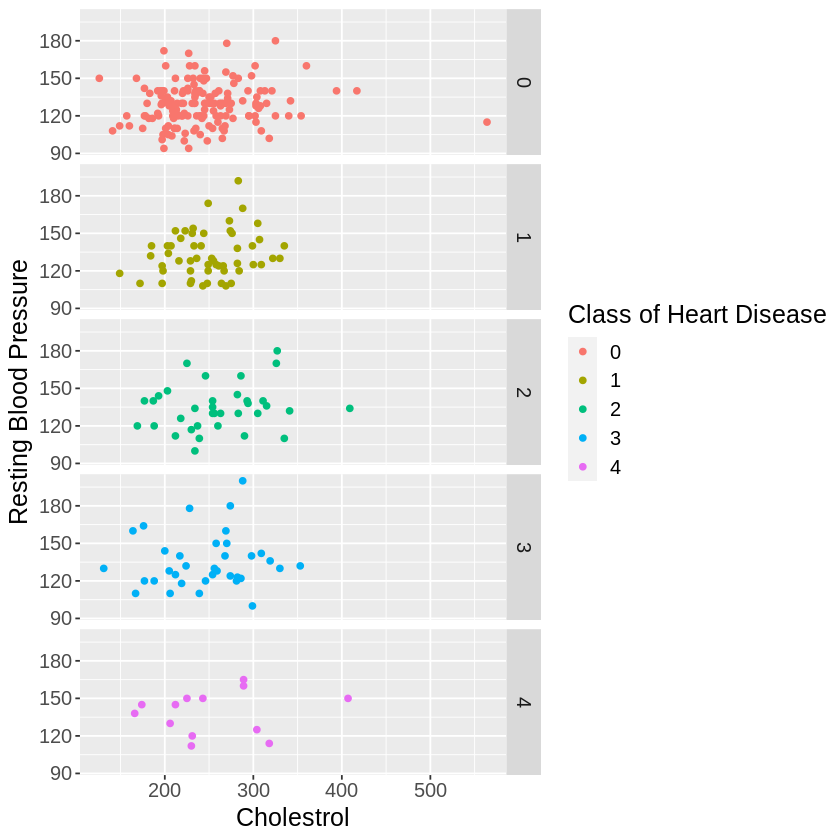

In [99]:
chol_vs_trestbps <- cleveland_data |>
                    ggplot(aes(x = chol, y = trestbps, color = as.factor(num))) +
                    geom_point() +
                    facet_grid(rows = vars(num)) +
                    labs(x = "Cholestrol", y = "Resting Blood Pressure", color = "Class of Heart Disease") +
                    theme(text = element_text(size = 15))
chol_vs_trestbps

Again, there seems there is no clear relationship between these two variables. After some more plots we were not able to conclusively visualize a relationship between any of the predictor variables and severity of heart disease. However, we noticed there did seem to be a relationship between variables when we consider simply having heart disease (levels 1,2,3,4) to not having heart disease (level 0).

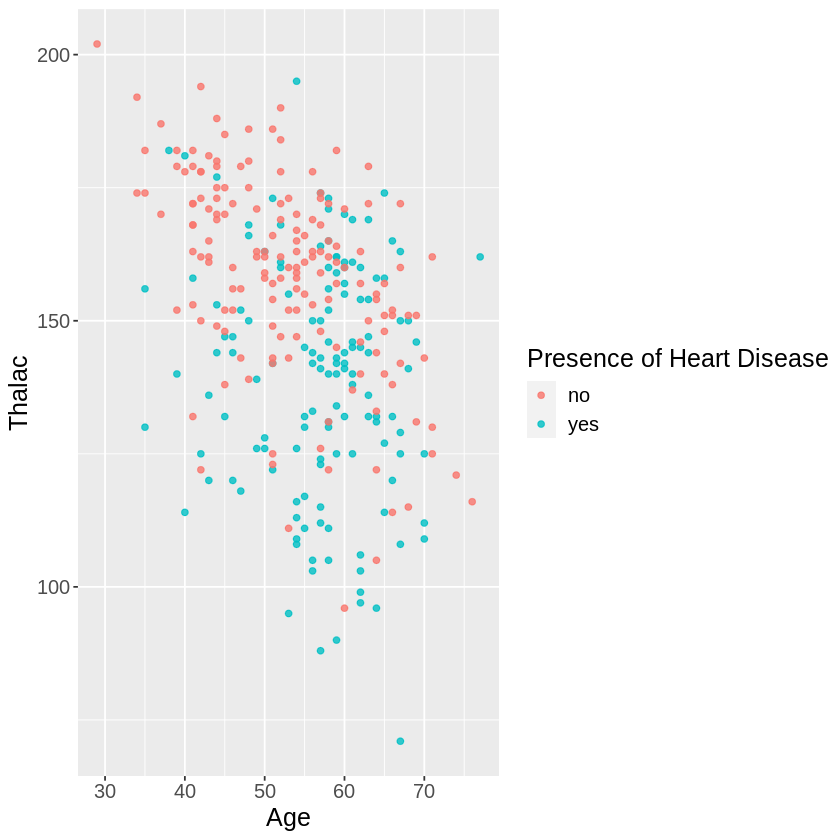

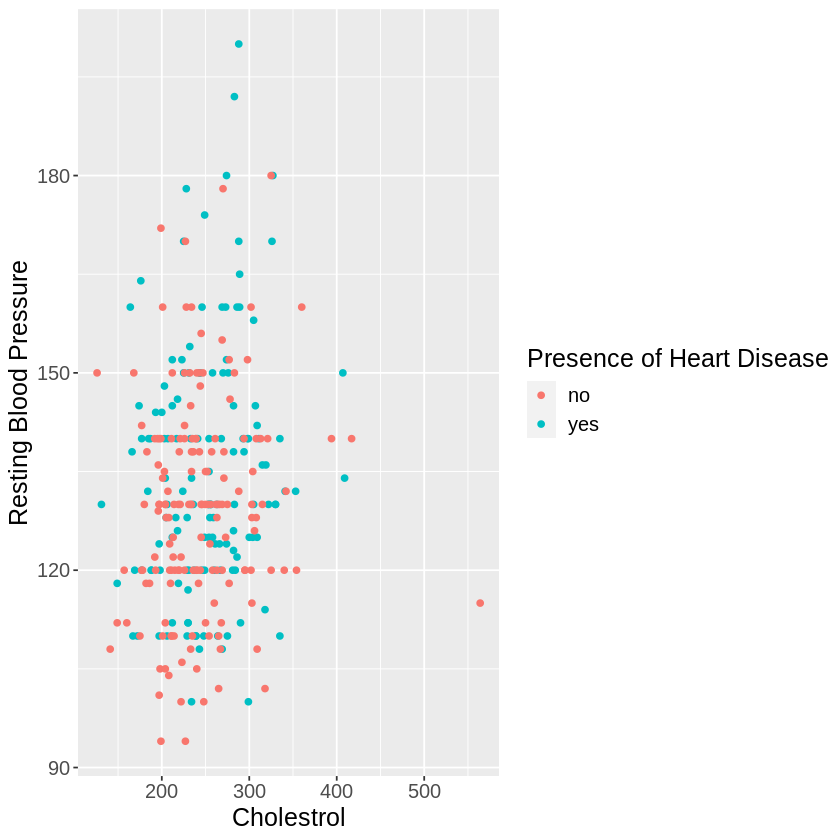

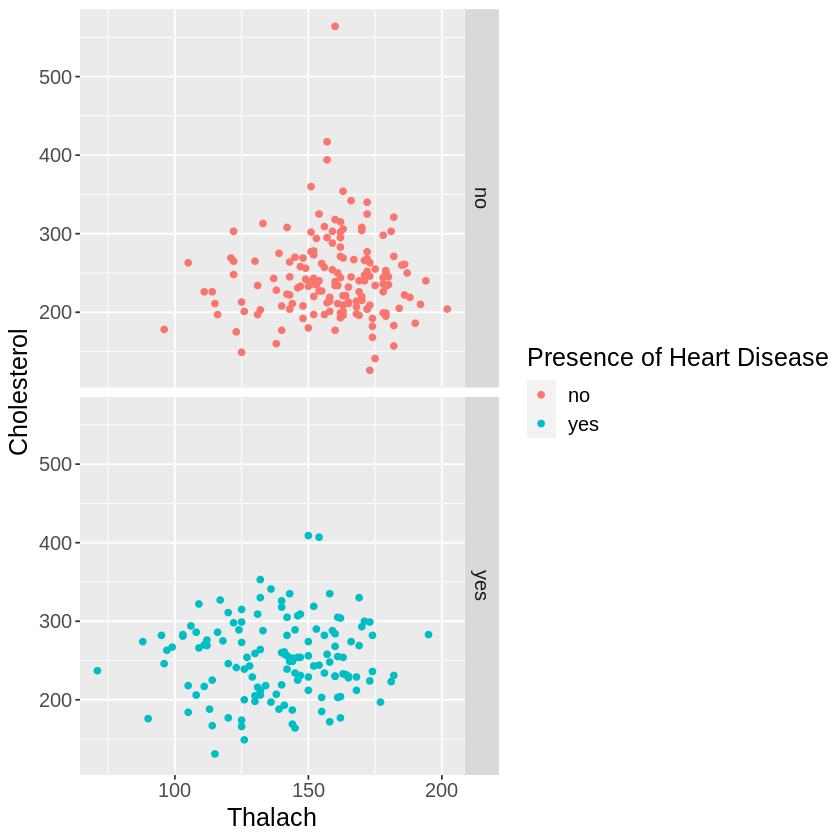

In [100]:
heart_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(num_alt = as_factor(hd))
heart_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(num_alt = as_factor(hd))
heart_data_alt <- rbind(heart_have_disease, heart_no_disease)

age_vs_thalac1 <- heart_data_alt |>
                    ggplot(aes(x = age, y = thalach, color = hd)) +
                    geom_point(alpha = .8) +
                    labs(x = "Age", y = "Thalac", color = "Presence of Heart Disease") +
                    theme(text = element_text(size = 15))
age_vs_thalac1

chol_vs_trestbps2 <- heart_data_alt |>
                    ggplot(aes(x = chol, y = trestbps, color = hd)) +
                    geom_point(alpha = 1) +
                    #facet_grid(rows = vars(hd)) +
                    labs(x = "Cholestrol", y = "Resting Blood Pressure", color = "Presence of Heart Disease") +
                    theme(text = element_text(size = 15))
chol_vs_trestbps2

thalach_vs_chol2 <- heart_data_alt |>
                    ggplot(aes(x = thalach, y = chol, color = hd)) +
                    geom_point(alpha = 1) +
                    facet_grid(rows = vars(hd)) +
                    labs(x = "Thalach", y = "Cholesterol", color = "Presence of Heart Disease") +
                    theme(text = element_text(size = 15))
thalach_vs_chol2

A possible explanation is that there is an overwhelming amount of observations with level 0 heart disease, compared to the other levels. When we combine the levels 1-4, there is a close to even split of having heart disease to not having heart disease. Thus, we changed our question to: Can we use the health attributes available to us to predict whether a future patient (with an unknown diagnosis) has heart disease?

In [101]:
# Percentages of levels 0-4
num_obs_c <- nrow(cleveland_data)
level_percentage_c <- cleveland_data |>
    group_by(num) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_c * 100
        )
level_percentage_c

num,count,percentage
<fct>,<int>,<dbl>
0,160,53.872054
1,54,18.181818
2,35,11.784512
3,35,11.784512
4,13,4.377104


**We thus added a binary classification column to our data set and added an additional set**

In [102]:
# Adding column indicating yes or no for presence of heart disease

cl_have_disease <- cleveland_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))
cl_no_disease <- cleveland_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))
cl_data_alt <- rbind(cl_have_disease, cl_no_disease)

In [103]:
# Loading in Hungarian data set

URL2 <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/reprocessed.hungarian.data"

hungarian_data <- read_delim(URL2, col_names = FALSE, delim = " ", show_col_types = FALSE)

colnames(hungarian_data) <- c("age", "sex", "cp", "trestbps", 
                              "chol", "fbs", "restecg", "thalach", 
                              "exang", "oldpeak", "slope", "ca", "thal", "num")


# Combine levels 1,2,3,4 into hd column. Levels 1-4 as "yes", level 0 as "no."

hung_have_disease <- hungarian_data |>
    filter(num == 1 | num == 2 | num == 3 | num == 4) |>
    mutate(hd = "yes") |>
    mutate(hd = as_factor(hd))

hung_no_disease <- hungarian_data |>
    filter(num == 0) |>
    mutate(hd = "no") |>
    mutate(hd = as_factor(hd))

hung_data_alt <- rbind(hung_have_disease, hung_no_disease)

In [104]:
heart_data <- rbind(hung_data_alt, cl_data_alt) |>
    select(-num)
heart_data

age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
49,0,3,160,180,0,0,156,0,1.0,2,-9,-9,yes
48,0,4,138,214,0,0,108,1,1.5,2,-9,-9,yes
37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
58,1,2,136,164,0,1,99,1,2.0,2,-9,-9,yes
49,1,4,140,234,0,0,140,1,1.0,2,-9,-9,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
35,1,2,122,192,0,0,174,0,0.0,1,0,3,no
56,1,2,130,221,0,2,163,0,0.0,1,0,7,no
56,1,2,120,240,0,0,169,0,0.0,3,0,3,no


In [105]:
# Percentages of hd (yes, no) 

num_obs_h <- nrow(heart_data)
heart_proportions <- heart_data |>
    group_by(hd) |>
    summarize(
        count = n(),
        percentage = n() / num_obs_h * 100
        )
heart_proportions

hd,count,percentage
<fct>,<int>,<dbl>
yes,243,41.11675
no,348,58.88325


Now with a more even split and some relationships visualized, we begin our planned analysis.

**Planned Analysis**

In [106]:
# Creating Training and Testing Data Sets

heart_split <- initial_split(heart_data, prop = 0.75, strata = hd)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

**Finding the Best Predictors using Forward Selection**

In order to ensure all of our group members had equal work to do, we decided to find the best predictors first before we ran our k-nn algorithm. Since we have $13$ variables to work with, we chose the method of forward selection to select the best predictors. According to the <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">textbook</a>, best subset selection is a method that trains all combinations of predictors and chooses the best accuracy. However, the method can become very slow once the number of predictors reaches 10 (Timbers et al., 2022). With $m = 13$ variables, we would have to train $2^m-1=8191$ models. Therefore, we chose to implement the method of forward selection, which chooses a list of candidate models and is more efficient to run (since it only trains $1/2m(m+1)=91$ models). The only tradeoff is perhaps a reduction in possible accuracy since not all possible models are trained (Timbers et al., 2022). We felt this method fit the requirements of our project.

Warning: Code takes 8-9 min. to run

In [107]:
# Implementing Forward Selection Code to find best predictors
names <- colnames(heart_training |> select(-hd))

# Create a tibble to store accuracies
preds_accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# Create a model spec
knn_FS_spec <- nearest_neighbor(weight_func = "rectangular",
                             neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a 5-fold cross-validation object
heart_vfold_preds <- vfold_cv(heart_training, v = 5, strata = hd)

# Stores selected predictors
selected <- c()
# For every size from 1 to 13 predictors
for (i in 1:13) {
    # Stores preds not yet added
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # For each combo of preds we are creating a model string
        # and tuning the resultant classifier while collecting the accuracy
        # of the best k
        preds_new <- c(selected, names[[j]])
        model_string <- paste("hd", "~", paste(preds_new, collapse="+"))
        heart_FS_recipe <- recipe(as.formula(model_string),
                                data = heart_training) |>
                            step_scale(all_predictors()) |>
                            step_center(all_predictors())
        acc <- workflow() |>
            add_recipe(heart_FS_recipe) |>
            add_model(knn_FS_spec) |>
            tune_grid(resamples = heart_vfold_preds, grid = 10) |>
            collect_metrics() |>
            filter(.metric == "accuracy") |>
            summarize(mx = max(mean))
        acc <- acc$mx |> unlist()
        # Adding the result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    preds_accuracies <- preds_accuracies |>
        add_row(size = i,
                model_string = models[[jstar]],
                accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}
preds_accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,hd ~ oldpeak,0.7043508
2,hd ~ oldpeak+cp,0.7813449
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
5,hd ~ oldpeak+cp+thal+fbs+slope,0.8062944
⋮,⋮,⋮
9,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca,0.8083895
10,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach,0.8039451
11,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age,0.8151061


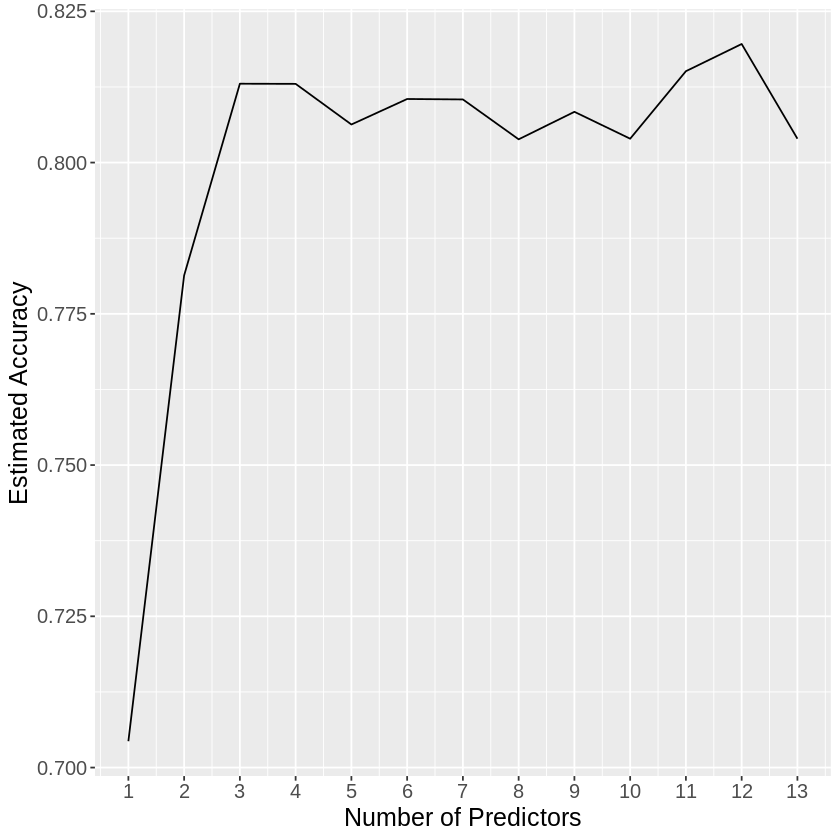

In [108]:
best_preds_plot <- ggplot(preds_accuracies, aes(x = size, y = accuracy)) +
    geom_line() +
    xlab("Number of Predictors") +
    ylab("Estimated Accuracy") +
    scale_x_continuous(breaks = 1:13) +
    theme(text = element_text(size = 15))

best_preds_plot

In [109]:
best_preds <- preds_accuracies |> slice(3,4,12)
best_preds

size,model_string,accuracy
<int>,<chr>,<dbl>
3,hd ~ oldpeak+cp+thal,0.8130360
4,hd ~ oldpeak+cp+thal+fbs,0.8130110
12,hd ~ oldpeak+cp+thal+fbs+slope+sex+restecg+exang+ca+thalach+age+chol,0.8196011


The best accuracy comes from using 12 predictors. However, this could be due to an overfitting of data, given that it involves a lot of predictors and it comes after some oscillation of accurracy in the data. The <a href="https://datasciencebook.ca/classification2.html#predictor-variable-selection">textbook</a> also warns, that with many models to train there is an increased possibility of obtaining a model with a high accuracy but a low true accuracy when tested on the test set (Timbers et al., 2022). So choosing 12 predictors might not be the best option. The next best accuracy comes from using 3 and 4 predictors which produce a similar accuracy, with 3 being slightly better. We decided to choose the "elbow" of the plot which is at 3 predictors. Thus, the best predictors are "oldpeak", "cp", and "thal".

**Tuning the Classifier**

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.7226899,10,0.01630057,Preprocessor1_Model01
1,roc_auc,binary,0.6886715,10,0.01839879,Preprocessor1_Model01
2,accuracy,binary,0.7158235,10,0.01364730,Preprocessor1_Model02
2,roc_auc,binary,0.7489091,10,0.01552186,Preprocessor1_Model02
3,accuracy,binary,0.7427975,10,0.02007331,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
48,roc_auc,binary,0.8508472,10,0.01051962,Preprocessor1_Model48
49,accuracy,binary,0.7943281,10,0.01891293,Preprocessor1_Model49
49,roc_auc,binary,0.8515088,10,0.01008878,Preprocessor1_Model49


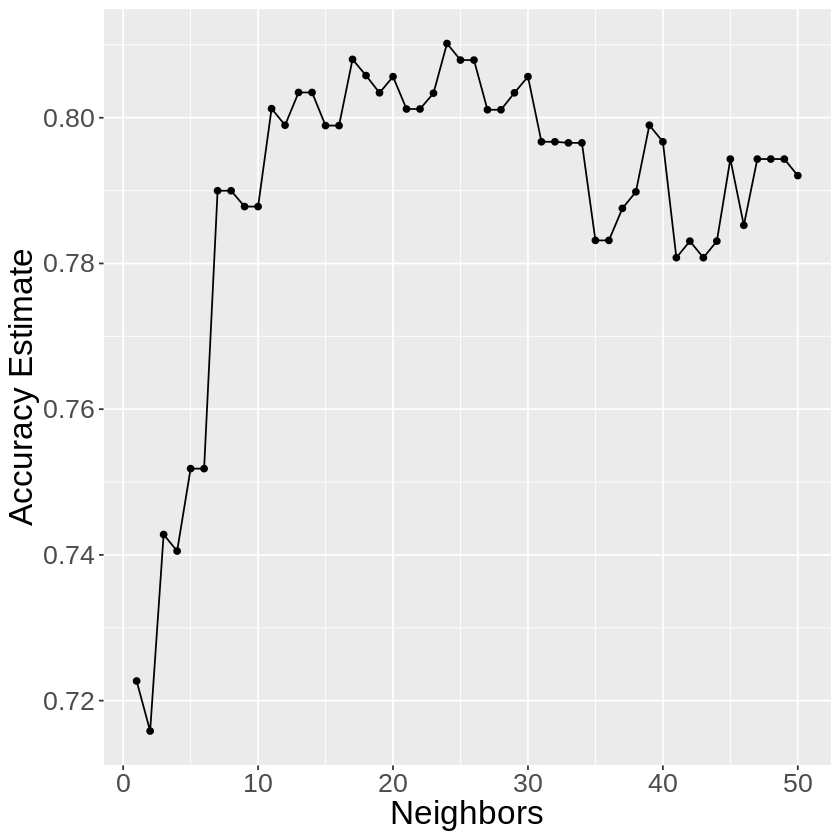

In [110]:
# Creating a 10-fold cross-validation object
heart_vfold <- vfold_cv(heart_training, v = 10, strata = hd)

# Preparing the recipe according to the best predictors as found above
heart_recipe <- recipe(hd ~ oldpeak + cp + thal + slope, data = heart_training) |>
                  step_scale(all_predictors()) |>
                  step_center(all_predictors())

# K-nn Classification spec
knn_spec_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
              set_engine("kknn") |>
              set_mode("classification")

# Setting possible values of best K to be in between 1 and 50
gridvals <- tibble(neighbors = seq(1, 50))

# Combining everything into a workflow and collecting the metrics to identify the best value of K
knn_results <- workflow() |>
                  add_recipe(heart_recipe) |>
                  add_model(knn_spec_tune) |>
                  tune_grid(resamples = heart_vfold, grid = gridvals) |>
                  collect_metrics()

knn_results

accuracies <- knn_results |>
  filter(.metric == "accuracy")

# Creating a cross-validation plot to visualise accuracies for the different values of K
cross_val_plot <- accuracies |> 
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Neighbors", y = "Accuracy Estimate") +
                    theme(text = element_text(size = 20))

cross_val_plot

In [111]:
# Choosing the best value of K
conclusions <- knn_results |>
                filter(.metric == "accuracy") |>
                select(neighbors, mean, std_err) |>
                arrange(mean) |>
                tail(1)

conclusions

neighbors,mean,std_err
<int>,<dbl>,<dbl>
24,0.8101866,0.01685421


**From the above conclusions, we can see that the best value for K to be used is 24.**

In [112]:
#Retraining the classifer 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 24) |>
    set_engine("kknn") |>
    set_mode("classification")

knn_fit <- workflow() |>
    add_recipe(heart_recipe) |>
    add_model(knn_spec) |>
    fit(data = heart_training)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(24,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1873589
Best kernel: rectangular
Best k: 24

In [113]:
#Predicting the labels in the test set
heart_test_predictions <- predict(knn_fit, heart_testing) |>
    bind_cols(heart_testing)
heart_test_predictions 

.pred_class,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,hd
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
yes,37,1,4,140,207,0,0,130,1,1.5,2,-9,-9,yes
yes,65,1,4,140,306,1,0,87,1,1.5,2,-9,-9,yes
yes,54,0,3,130,294,0,1,100,1,0.0,2,-9,-9,yes
no,41,1,4,110,289,0,0,170,0,0.0,-9,-9,6,yes
yes,47,0,4,120,205,0,0,98,1,2.0,2,-9,6,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
no,51,0,3,120,295,0,2,157,0,0.6,1,0,3,no
no,76,0,3,140,197,0,1,116,0,1.1,2,0,3,no
no,44,0,3,118,242,0,0,149,0,0.3,2,1,3,no


In [114]:
#Computing the accuracy
heart_accuracies <- heart_test_predictions |>
    metrics(truth = hd, estimate = .pred_class) |>
    filter(.metric =="accuracy")
heart_accuracies

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8175676


In [115]:
#Looking at the confusion matrix
confusion <- heart_test_predictions |>
             conf_mat(truth = hd, estimate = .pred_class)
confusion 

          Truth
Prediction yes no
       yes  44 10
       no   17 77

**Discussion**

1. summarize what you found
2. discuss whether this is what you expected to find?
3. discuss what impact could such findings have?
4. discuss what future questions could this lead to?

**References (APA?)**

Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.

Johns Hopkins Medicine (2017, January 11). _Updated Classification System Captures Many More People at Risk for Heart Attack_. https://www.hopkinsmedicine.org/news/media/releases/updated_classification_system_captures_many_more_people_at_risk_for_heart_attack

Timbers, T., Campbell, T., & Lee, M. (2022). Data science: A first introduction. CRC Press LLC.

**Questions for TA**

How formal do references have to be? Can they be blogs or just academic sources?

Is the order of things okay? In our proposal we started with the question of how to classify an unknown label with a level of heart disease 0-4, then we found it hard to visualize any relationships in the data, so we decided to classify based on simply having heart disease to not (binary) and added an additional data set from another area. Should I begin by explaining this again, or should I just describe our final binary classification question and describe the 2 data sets, in the introduction? And mention our exploratory analysis afterwards?

**Notes for teammates**

The tuning of the classifier neighbours change slightly to k = 24 -> k = 26 when run out of order, for some reason. Just make sure everything is run in order.